In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
import numpy as np 

# https://medium.com/@13jesusegui/python-file-explorer-generation-and-nesting-of-file-dictionaries-2c486276f8d6

In [2]:
dir_of_interest = os.getcwd()

In [3]:
def get_folder_size(dir_of_interest):
    size = 0
    for path, dirs, files in os.walk(dir_of_interest):
        for f in files:
            fp = os.path.join(path, f)
            if os.path.isfile(fp):
                size += os.path.getsize(fp)
    return size

def build_dod(dir_of_interest, ignore_dir=False):
    dod = {}

    for subdir, dirs, files in os.walk(dir_of_interest):
        dirs[:] = [d for d in dirs if d != ignore_dir] # remove files to ignore from DoD

        parent = os.path.basename(subdir) or subdir # retrieve name of subdir
        subdir_size = get_folder_size(subdir)
        dod.setdefault(parent, {})
    
        # add subdirectories as children
        for d in dirs: # for each subdir in dir 
            folder_size = get_folder_size((os.path.join(subdir, d)))
            dod[parent][d] = { # store an edge (parent-->d) with attribute 'dir' 
                "type": "folder",
                "size_bytes": folder_size} # store an edge (parent-->filename) with attribute 'size_bytes'

        # add files as children
        for file in files: # for each file in files
            file_name = os.path.basename(file) # get filename
            full_path = os.path.join(subdir, file) # get the full path for calculating size
            # size calculation...
            try:
                size = os.path.getsize(full_path)
            except OSError:
                size = None
            dod[parent][file_name] = {
                "type": "file",
                "size_bytes": size} # store an edge (parent-->filename) with attribute 'size_bytes'

    return dod


In [4]:
get_folder_size(r'c:\Users\rqg886\Desktop\dir_to_graph')

377263341

In [5]:
get_folder_size(r'c:\Users\rqg886\Desktop\dir_to_graph\folder2')

9

In [6]:
get_folder_size(r'c:\Users\rqg886\Desktop\dir_to_graph\folder1\file_within_folder.py')

0

In [7]:
h = build_dod(dir_of_interest, '.venv')

In [8]:
h

{'dir_to_graph': {'folder1': {'type': 'folder', 'size_bytes': 108},
  'folder2': {'type': 'folder', 'size_bytes': 9},
  '.gitignore': {'type': 'file', 'size_bytes': 7},
  'file_structure': {'type': 'file', 'size_bytes': 689025},
  'test.ipynb': {'type': 'file', 'size_bytes': 47179},
  'test.py': {'type': 'file', 'size_bytes': 0}},
 'folder1': {'file_within_folder.py': {'type': 'file', 'size_bytes': 108}},
 'folder2': {'folder_within_folder': {'type': 'folder', 'size_bytes': 9}},
 'folder_within_folder': {'child_of_child.json': {'type': 'file',
   'size_bytes': 9}}}

In [9]:
#G = nx.from_dict_of_dicts(h, create_using=nx.DiGraph())
G = nx.DiGraph()
for parent, children in h.items():
    G.add_node(parent, type="folder")
    for child, attrs in children.items():
        G.add_node(child, **attrs)
        G.add_edge(parent, child)

In [10]:
get_folder_size(r'c:\Users\rqg886\Desktop\dir_to_graph\folder1')

108

In [11]:
sizes = []
for node in G.nodes():
    size = G.nodes[node].get("size_bytes", None)
    if size is None:
        sizes.append(0.0)  # Default size
    else:
        sizes.append(float(size)/1000)
    print(node, ' --> ', sizes)

dir_to_graph  -->  [0.0]
folder1  -->  [0.0, 0.108]
folder2  -->  [0.0, 0.108, 0.009]
.gitignore  -->  [0.0, 0.108, 0.009, 0.007]
file_structure  -->  [0.0, 0.108, 0.009, 0.007, 689.025]
test.ipynb  -->  [0.0, 0.108, 0.009, 0.007, 689.025, 47.179]
test.py  -->  [0.0, 0.108, 0.009, 0.007, 689.025, 47.179, 0.0]
file_within_folder.py  -->  [0.0, 0.108, 0.009, 0.007, 689.025, 47.179, 0.0, 0.108]
folder_within_folder  -->  [0.0, 0.108, 0.009, 0.007, 689.025, 47.179, 0.0, 0.108, 0.009]
child_of_child.json  -->  [0.0, 0.108, 0.009, 0.007, 689.025, 47.179, 0.0, 0.108, 0.009, 0.009]


In [12]:
for node, size in zip(G.nodes(), sizes):
    print(f"{node} --> {size}")


dir_to_graph --> 0.0
folder1 --> 0.108
folder2 --> 0.009
.gitignore --> 0.007
file_structure --> 689.025
test.ipynb --> 47.179
test.py --> 0.0
file_within_folder.py --> 0.108
folder_within_folder --> 0.009
child_of_child.json --> 0.009


In [13]:
color_map = []
for node in G.nodes():
    node_type = G.nodes[node].get("type", "unknown")
    if node_type == "file":
        color_map.append("skyblue")
    elif node_type == "folder":
        color_map.append("lightgreen")
    else:
        color_map.append("red")  # default


In [14]:
def normalize_node_size(sizes, normalization='min_max'):
    # Convert to array for easier math
    size_array = np.array(sizes, dtype=float)

    if normalization=='min_max':
        # Min-max normalization to [0, 1]
        min_size = size_array.min()
        max_size = size_array.max()

        if max_size == min_size:
            return np.ones_like(size_array) # avoid divide-by-zero
        else:
            return (size_array - min_size) / (max_size - min_size) 
        
    elif normalization=='log':
        return np.log1p(size_array)
    
norm_sizes = normalize_node_size(sizes, normalization='min_max')

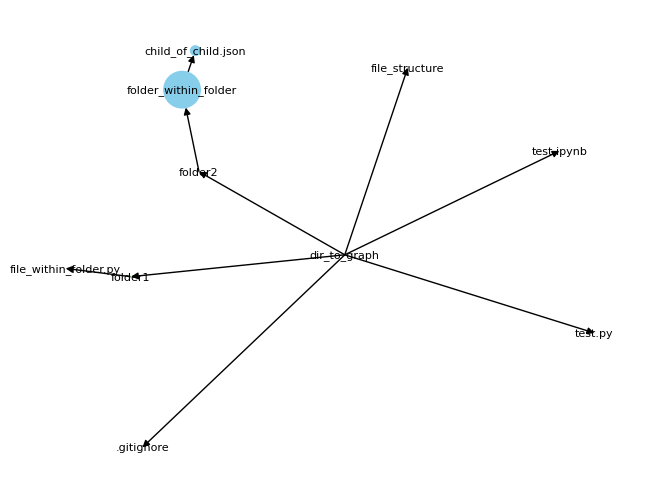

In [15]:
from networkx.readwrite import json_graph
data = json_graph.tree_data(G, root='dir_to_graph')
H = json_graph.tree_graph(data)

nx.draw(H, with_labels=True, font_size=8, node_color=color_map, node_size=sizes)

In [138]:
len(G.edges())

9

In [137]:
len(G.nodes())

10